In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from synthpop.models import AxtellModel
from synthpop.infer import Infer, SMCABC
import pygtc

In [9]:
model = AxtellModel(N=1000, v=1)

def loss(x):
    ts, ass, _, efforts = x
    init_mean_efforts = efforts[0].mean()
    previous_efforts = efforts[0].copy()
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        previous_efforts = model.reconstruct_effort(previous_efforts, agent, efforts[i+1])
    return (previous_efforts.mean() - init_mean_efforts).reshape(1,1) + 1

def meta_generator(params):
    def generator(n_agents):
        E_a, E_b, T_a, T_b, P_k, P_t, beta, a, b = params
        # Draw effort levels
        es  = np.random.beta(E_a, E_b, size=n_agents)
        # Draw preferences
        ths = np.random.beta(T_a, T_b, size=n_agents)
        # Draw rates
        phs = np.random.gamma(P_k, P_t, size=n_agents)
        return es, ths, phs, beta.item(), a.item(), b.item()
    return generator

prior = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
                                    torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5])), reinterpreted_batch_ndims=1)

In [10]:
infer = Infer(model=model, meta_generator=meta_generator, prior=prior, loss=loss)
infer_method = SMCABC(num_particles = 100, num_initial_pop=10_000, num_simulations=20_000, epsilon_decay=0.6)
trained_meta_generator = infer.fit(infer_method, num_workers=-1)

Running 10000 simulations in 10000 batches.: 100%|██████████| 10000/10000 [00:28<00:00, 348.26it/s]
/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/sbi/inference/abc/smcabc.py:569: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1702.)
  torch.cholesky(kernel_variance_scale * population_cov)
Running 24 simulations in 24 batches.: 100%|██████████| 24/24 [00:00<00:00, 154.26it/s]


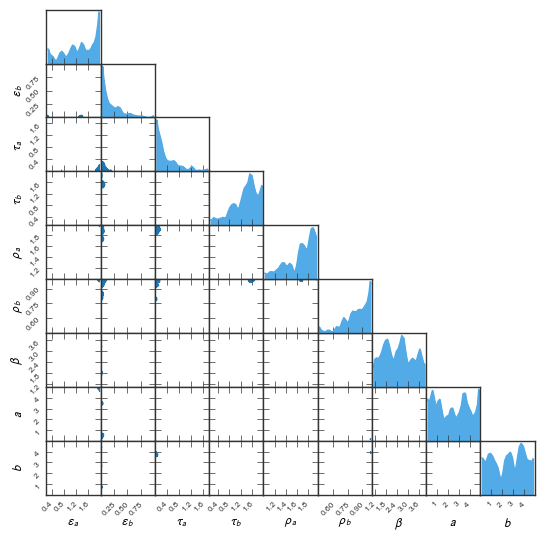

In [14]:
samples = trained_meta_generator.samples.numpy()
pygtc.plotGTC([samples], 
              nContourLevels=1, 
              paramNames=[r"$\epsilon_a$", r"$\epsilon_b$",
                        r"$\tau_a$", r"$\tau_b$",
                        r"$\rho_a$", r"$\rho_b$",
                        r"$\beta$", r"$a$", r"$b$"]);

In [15]:
# get predicted efforts.
def get_mean_efforts(ts, ass, a_efforts):
    mean_efforts = [a_efforts[0].mean()]
    last_efforts = a_efforts[0]
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        new_efforts = model.reconstruct_effort(last_efforts, agent, a_efforts[i+1])
        mean_efforts.append(new_efforts.mean())
        last_efforts = new_efforts
    return mean_efforts

prior_pred_efforts = []
post_pred_efforts = []
post_times = []
prior_times = []
n = 25
for j in range(n):
    # prior
    generator = meta_generator(prior.sample())
    ts, ass, _, a_efforts = model(generator)
    mean_efforts= get_mean_efforts(ts, ass, a_efforts)
    prior_pred_efforts.append(mean_efforts)
    prior_times.append(ts)
    # trained
    generator = trained_meta_generator()
    ts, ass, _, a_efforts = model(generator)
    mean_efforts = get_mean_efforts(ts, ass, a_efforts)
    post_pred_efforts.append(mean_efforts)
    post_times.append(ts)

Text(0.5, 0, 'Time')

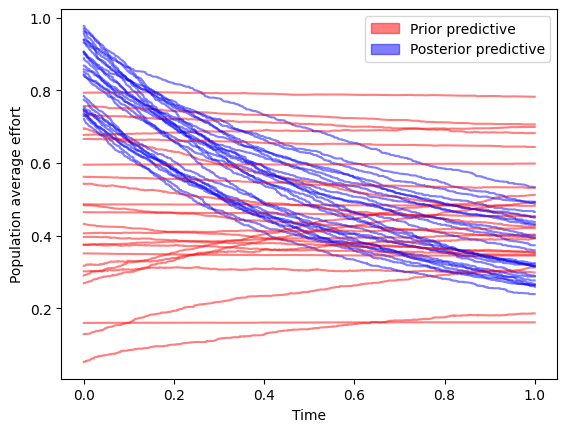

In [16]:
fig, ax = plt.subplots(1,1)
for i in range(len(post_pred_efforts)):
    ax.plot(post_times[i], post_pred_efforts[i], alpha=0.5, c='b')
    ax.plot(prior_times[i], prior_pred_efforts[i], alpha=0.5, c='r')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='Prior predictive')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Posterior predictive')
plt.legend(handles=[red_patch, blue_patch])
plt.ylabel("Population average effort")
plt.xlabel("Time")